In [1]:
import os, sys
import json
import random
import pickle
from typing import List, Tuple, Dict

from itertools import product
import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer, BertModel
# from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import Dataset_Reader
from tqdm import tqdm

/home/tom/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def save_model(model, filepath):
    """
    Save PyTorch model parameters to a file.

    Args:
    - model (torch.nn.Module): PyTorch model to save.
    - filepath (str): Filepath to save the model parameters.
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model parameters saved to '{filepath}'")

def load_model(model, filepath):
    """
    Load PyTorch model parameters from a file.

    Args:
    - model (torch.nn.Module): PyTorch model to load parameters into.
    - filepath (str): Filepath to the saved model parameters.
    """
    model.load_state_dict(torch.load(filepath))
    print(f"Model parameters loaded from '{filepath}'")
    
def save_tensor(tensor, dir, filename):
    """
    Save PyTorch tensor to a file.

    Args:
    - tensor (torch.Tensor): PyTorch tensor to save.
    - dir (str): Directory to save the tensor.
    - filename (str): Filename to save the tensor.
    """
    
    if not os.path.exists(os.path.join(dir)):
        os.makedirs(os.path.join(dir))
        
    filepath = os.path.join(dir, filename)
    torch.save(tensor, filepath)
    print(f"Tensor saved to '{filepath}'")

def load_tensor(filepath):
    """
    Load PyTorch tensor from a file.

    Args:
    - filepath (str): Filepath to the saved tensor.

    Returns:
    - tensor (torch.Tensor): Loaded PyTorch tensor.
    """
    tensor = torch.load(filepath)
    # print(f"Tensor loaded from '{filepath}'")
    return tensor

In [3]:
with open('../data/train.json', 'r') as file:
    train_data = json.load(file)

with open('../data/dev.json', 'r') as file:
    test_data = json.load(file)

In [4]:
TRAIN_data = Dataset_Reader(train_data)
TEST_data = Dataset_Reader(test_data)
print(len(TRAIN_data))
# TRAIN_data_batched = DataLoader(TRAIN_data, batch_size = 5, shuffle= True)

247


In [5]:
def max_length(documents, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
    """
    Generate the maximum length of each sentence in each document. This is necessary to make sure there is a fixed sentence-length 
    for each document before we pass the sentence embeddings through the model.

    Returns: {document index: length of longest sentence}

    """
    max_l_dict = {}
    
    for sentence in documents.texts:
        size = []

        inputs = tokenizer(sentence[2], return_tensors="pt", truncation=True, padding=True, add_special_tokens= True)

        size.append(inputs['input_ids'].size(1))
        
        max_l_dict[sentence[0]] = max(size)
    
    dict_keys = list(max_l_dict.keys())
    reference_keys = list(range(len(documents)))  
    for key in reference_keys:
        if key not in dict_keys:
            max_l_dict[key] = 0
            
    return max_l_dict

In [6]:
def get_batched_data(data: Dataset, batch_size:int = 1) ->  Tuple[List,List,List]:
    doc_idx = []
    batched_texts = []
    batched_labels = []
    for start, stop in zip(range(0,len(data)-batch_size,batch_size), range(batch_size,len(data),batch_size)):
        idxs = []
        texts = []
        labels = []
        for idx in range(start,stop):
            idxs.append(idx) 
            [texts.append(text) for text in data[idx]['text']]
            [labels.append(label) for label in data[idx]['label']]
        
        doc_idx.append(idxs)
        batched_texts.append(texts)
        batched_labels.append(labels)
    return doc_idx, batched_texts, batched_labels

In [7]:
max_lens_train = max_length(TRAIN_data)

In [8]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TRAIN_data, batch_size= 1)

In [9]:
def label_encode(target_variables : list) -> LabelEncoder:
    """
    Encode target variables.
    
    Args:
    - target_variables (list or array-like): List of target variable strings.
    
    Returns:
    - lb (object): class object used to tranform and inverse transform.
    """
    le = LabelEncoder()
    le = le.fit(target_variables)
    
    return le

def get_model_data(data:torch.utils.data.Dataset, encoder: LabelEncoder,
                   tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                   model= BertModel.from_pretrained('bert-base-uncased'),
                   num_of_docs:int = None,
                   ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(data.labels)
    sent_emb = []
    max_sent_length = 128
    if num_of_docs is None:
        for idx, sentence in enumerate(data.texts):
            inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                padding='max_length', max_length = max_sent_length,
                                add_special_tokens= True)
            with torch.no_grad():
                output = model(**inputs)
            sent_emb.append(output.last_hidden_state[:,0,:])
    else:
        for idx, sentence in enumerate(data.texts):
            if sentence[0] < num_of_docs:
                inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                    padding='max_length', max_length = max_sent_length,
                                    add_special_tokens= True)
                with torch.no_grad():
                    output = model(**inputs)
                sent_emb.append(output.last_hidden_state[:,0,:]) 
        numerical_labels = numerical_labels[:len(sent_emb)]
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train

def get_model_data_batched(indexes:List, texts:List, labels:List, encoder:LabelEncoder,max_len_dict:Dict,
                           tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                           model= BertModel.from_pretrained('bert-base-uncased'),
                           ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(labels)
    sent_emb = []
    for idx, sentence in enumerate(texts):
        try:
            max_sent_length = max([max_len_dict[i] for i in indexes])
        except KeyError:
            continue
        inputs = tokenizer(sentence.lower(),  return_tensors="pt", truncation= True,
                            padding='max_length', max_length = max_sent_length,
                            add_special_tokens= True)
        with torch.no_grad():
            output = model(**inputs)
        sent_emb.append(output.last_hidden_state[:,0,:])
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train    
    

list_of_targets = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']
label_encoder = label_encode(list_of_targets)

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class BiLSTM(nn.Module):
    def __init__(self,
                input_size:int = 768,
                hidden_size:int = 256,
                num_layers:int = 2,
                output_size:int = 13,
                dropout:float = 0.1
                ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              bidirectional=True)
        
        self.dense = nn.Sequential(nn.Dropout(p=dropout),
                                   nn.Linear(hidden_size*2, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_size),
                                   nn.Softmax(dim=1),
        )
        
        self.apply(init_weights)
        
    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers
        out = self.dense(lstm_out)

        return out

In [11]:
# TRAIN_emb, TRAIN_labels = get_model_data(data= TRAIN_data, encoder= label_encoder, num_of_docs= 10)
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)

In [12]:
def train(x_train, y_train, model, optimizer, loss_fc, num_epochs):
    model.train()
    loss_list = []
    acc_list = []
    model.train()
    # print(f'{"Starting Training":-^100}')
    for epoch in range(num_epochs+1):
        output = model(x_train)
        loss = loss_fc(output,y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if epoch%50 == 0:
            acc = sum(output.argmax(dim=1) == y_train)/ output.size(0)
            acc_list.append(acc)
            print(f"Epoch: {epoch} \t Loss: {loss.item():.5f} \t Accuracy: {acc*100:.2f}%")
            
    return loss_list, acc_list
            
def test_accuracy(x_test, y_test, model):
    model.eval()
    output = model(x_test)
    acc = sum(output.argmax(dim=1) == y_test)/ output.size(0)
    print(f"Test Accuracy {acc*100:.2f}%")
    return acc*100

In [13]:
def set_highest_to_one(tensor):
    max_val, max_idx = tensor.max(dim=1, keepdim=True)
    result = torch.zeros_like(tensor)
    result.scatter_(1, max_idx, 1)
    return result

In [14]:
def class_accuracy(conf_matrix):
    """
    Calculate accuracy for each class based on a confusion matrix.

    Parameters:
    conf_matrix (numpy.ndarray): Confusion matrix.

    Returns:
    list: List of accuracies for each class.
    """
    diagonal = np.diag(conf_matrix)

    row_sums = conf_matrix.sum(axis=1)

    accuracies = diagonal / row_sums.astype(float)

    return accuracies

In [15]:
def class_f1_score(conf_matrix, epsilon=1e-7):
    """
    Calculate F1 score for each class based on a confusion matrix.

    Parameters:
    conf_matrix (numpy.ndarray): Confusion matrix.
    epsilon (float): Smoothing term to avoid division by zero.

    Returns:
    list: List of F1 scores for each class.
    """
    
    tp = np.diag(conf_matrix)
    fp = conf_matrix.sum(axis=0) - tp
    fn = conf_matrix.sum(axis=1) - tp

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1_scores

In [27]:
def confusion_matrix(y_pred, y_true, num_classes):
    """
    Create a confusion matrix for label encodings in PyTorch.

    Parameters:
    y_pred (torch.Tensor): Predicted labels tensor.
    y_true (torch.Tensor): True labels tensor.
    num_classes (int): Number of classes.

    Returns:
    numpy.ndarray: Confusion matrix.
    """
    
    #y_pred = set_highest_to_one(y_pred)
    
    
    
    if y_pred.shape != y_true.shape:
        raise ValueError("Shapes of predictions and true labels must match. y_pred shape: {} y_true shape: {}".format(y_pred.shape, y_true.shape))

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    for pred, true in zip(y_pred_np, y_true_np):
        conf_matrix[pred, true] += 1

    return conf_matrix

In [17]:
def grid_search(parameters):
    keys = parameters.keys()
    values = parameters.values()
    
    combinations = list(product(*values))
    
    parameter_configurations = [{k: v for k, v in zip(keys, combination)} for combination in combinations]
    
    return parameter_configurations

In [18]:
def random_train_test_split(size, training_data_size):
    indices = np.arange(size)
    np.random.shuffle(indices)
    training_data_length = int(size * training_data_size)
    training_data_indices = indices[:training_data_length]
    test_data_indices = indices[training_data_length:]
    return training_data_indices, test_data_indices

In [19]:
def get_accuracy_value(item):
    return item[1][0]

In [20]:
def calculate_confusion_matrix(test_emb, test_labels, model):
    model.eval()
    output = model(test_emb)
    return confusion_matrix(output, test_labels, len(test_labels))
    

In [25]:
def grid_search_train_test(parameters):
    result = []
    parameter_configs = grid_search(parameters)
    
    for config in parameter_configs:
        batch_loss, batch_acc = [], []
        model = BiLSTM(hidden_size=config['hidden_size'], num_layers=config['num_layers'], dropout=config['dropout'])
        model_opt = torch.optim.Adam(model.parameters(), lr= config['learning_rate'])
        loss_function = nn.CrossEntropyLoss()
        print("Working with: ")
        print(config)
        print("\n")
        
        
        print(f'{"Starting Training":-^100}')
        model.train()
        for epoch in range(config['epochs']):
            # print(f"Epoch {epoch}")
            for idx in tqdm(range(246)):
                TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
                TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
                if TRAIN_emb.size(0) == 0:
                    continue
                output = model(TRAIN_emb)
                loss = loss_function(output,TRAIN_labels)
                
                model_opt.zero_grad()
                loss.backward()
                model_opt.step()
                
            print(f"Epoch: {epoch+1} \t Loss: {loss.item():.5f}")
            batch_loss.append(loss.item())
        
        confusion_matrix = None
        for i in range(29):
            TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
            TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
            conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model)
            if confusion_matrix:
                confusion_matrix = np.add(confusion_matrix, conf_matrix_helper)
            else:
                confusion_matrix = conf_matrix_helper
                
        accuracies = class_accuracy(confusion_matrix)
        f1_scores = class_f1_score(confusion_matrix)
        average_accuracy = np.mean(accuracies)
        average_f1 = np.mean(f1_scores)
        
        print("Accuracies: {accuracies} \n Average acccuracy: {average_accuracy}")
        print("F1 Scores: {f1_scores} \n Average F1: {average_f1}")
        
        result.append((config, (average_accuracy, average_f1)))
        
    return result

In [28]:
parameter_configs = {
    'epochs': [10, 20, 30],
    'learning_rate': [0.0001, 0.001, 0.01],
    'dropout': [0.0, 0.1, 0.2, 0.3],
    'hidden_size': [128, 256, 512],
    'num_layers': [1, 2, 3]
    }

result = grid_search_train_test(parameter_configs)

max_accuracy_config = max(result, key=get_accuracy_value)

print(max_accuracy_config)

Working with: 
{'epochs': 10, 'learning_rate': 0.0001, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

100%|██████████| 246/246 [00:06<00:00, 39.24it/s]


Epoch: 1 	 Loss: 2.32586


100%|██████████| 246/246 [00:05<00:00, 41.54it/s]


Epoch: 2 	 Loss: 2.32443


100%|██████████| 246/246 [00:05<00:00, 45.08it/s]


Epoch: 3 	 Loss: 2.30299


100%|██████████| 246/246 [00:05<00:00, 45.41it/s]


Epoch: 4 	 Loss: 2.25840


100%|██████████| 246/246 [00:05<00:00, 43.61it/s]


Epoch: 5 	 Loss: 2.25411


100%|██████████| 246/246 [00:05<00:00, 46.27it/s]


Epoch: 6 	 Loss: 2.25018


100%|██████████| 246/246 [00:06<00:00, 40.25it/s]


Epoch: 7 	 Loss: 2.23882


100%|██████████| 246/246 [00:05<00:00, 41.21it/s]


Epoch: 8 	 Loss: 2.22097


100%|██████████| 246/246 [00:05<00:00, 43.38it/s]


Epoch: 9 	 Loss: 1.95283


100%|██████████| 246/246 [00:05<00:00, 42.47it/s]


Epoch: 10 	 Loss: 2.01258


ValueError: Shapes of predictions and true labels must match. y_pred shape: torch.Size([96, 13]) y_true shape: torch.Size([96])

In [ ]:
# losses, accs = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,300)

In [ ]:
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)
# test_accuracy(TEST_emb, TEST_labels, model)

In [ ]:
model = BiLSTM(dropout=0.0, num_layers=1)
model_opt = torch.optim.Adam(model.parameters(), lr= 5e-5)
loss_function = nn.CrossEntropyLoss()

In [ ]:
batch_loss, batch_acc = [], []
# batch_counter = 0
# random_doc_indexes = random.sample([i for i in range(len(batched_texts))],k=10)
# print(random_doc_indexes)
print(f'{"Starting Training":-^100}')
model.train()
for epoch in range(20):
    # print(f"Epoch {epoch}")
    for idx in tqdm(range(246)):
        TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
        TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
        if TRAIN_emb.size(0) == 0:
            continue
        output = model(TRAIN_emb)
        loss = loss_function(output,TRAIN_labels)
        
        model_opt.zero_grad()
        loss.backward()
        model_opt.step()
        
    print(f"Epoch: {epoch+1} \t Loss: {loss.item():.5f}")
    batch_loss.append(loss.item())

    # # batch_counter += 1
    # # print(f"{f'BATCH NUMBER {batch_counter}':-^100}")
    #     TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
    #     TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
    #     if TRAIN_emb.size(0) == 0:
    #         continue
    #     # TRAIN_emb, TRAIN_labels = get_model_data_batched(doc_idxs[idx],batched_texts[idx],batched_labels[idx],label_encoder,max_lens_train)
    #     loss, acc = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,1)
    #     batch_loss.append(loss)
    #     batch_acc.append(acc)
    #     del TRAIN_emb, TRAIN_labels

-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:09<00:00, 24.67it/s]


Epoch: 1 	 Loss: 2.41102


100%|██████████| 246/246 [00:07<00:00, 31.41it/s]


Epoch: 2 	 Loss: 2.32699


100%|██████████| 246/246 [00:07<00:00, 31.27it/s]


Epoch: 3 	 Loss: 2.14745


100%|██████████| 246/246 [00:08<00:00, 30.49it/s]


Epoch: 4 	 Loss: 2.04829


100%|██████████| 246/246 [00:08<00:00, 29.74it/s]


Epoch: 5 	 Loss: 2.06316


100%|██████████| 246/246 [00:07<00:00, 30.76it/s]


Epoch: 6 	 Loss: 2.05664


100%|██████████| 246/246 [00:07<00:00, 30.86it/s]


Epoch: 7 	 Loss: 2.08549


100%|██████████| 246/246 [00:08<00:00, 29.40it/s]


Epoch: 8 	 Loss: 2.03122


100%|██████████| 246/246 [00:07<00:00, 31.87it/s]


Epoch: 9 	 Loss: 2.02196


100%|██████████| 246/246 [00:07<00:00, 31.45it/s]


Epoch: 10 	 Loss: 2.01100


100%|██████████| 246/246 [00:07<00:00, 32.76it/s]


Epoch: 11 	 Loss: 2.01911


100%|██████████| 246/246 [00:07<00:00, 31.89it/s]


Epoch: 12 	 Loss: 2.03949


100%|██████████| 246/246 [00:07<00:00, 31.38it/s]


Epoch: 13 	 Loss: 2.00497


100%|██████████| 246/246 [00:07<00:00, 31.37it/s]


Epoch: 14 	 Loss: 1.93509


100%|██████████| 246/246 [00:07<00:00, 32.01it/s]


Epoch: 15 	 Loss: 1.93260


100%|██████████| 246/246 [00:07<00:00, 32.31it/s]


Epoch: 16 	 Loss: 1.92965


100%|██████████| 246/246 [00:07<00:00, 33.36it/s]


Epoch: 17 	 Loss: 1.93059


100%|██████████| 246/246 [00:07<00:00, 31.99it/s]


Epoch: 18 	 Loss: 1.90713


100%|██████████| 246/246 [00:07<00:00, 32.45it/s]


Epoch: 19 	 Loss: 1.93041


100%|██████████| 246/246 [00:07<00:00, 31.13it/s]

Epoch: 20 	 Loss: 2.05209


In [ ]:
save_model(model, "../models/BiLSTM.pth")

Model parameters saved to '../models/BiLSTM.pth'


In [ ]:
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)
acc = 0
for i in range(29):
    TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
    TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
    acc += test_accuracy(TEST_emb, TEST_labels, model)
    
print(acc/29)

Test Accuracy 81.25%
Test Accuracy 33.81%
Test Accuracy 68.00%
Test Accuracy 68.52%
Test Accuracy 77.32%
Test Accuracy 85.96%
Test Accuracy 66.18%
Test Accuracy 73.45%
Test Accuracy 83.92%
Test Accuracy 89.21%
Test Accuracy 61.84%
Test Accuracy 72.12%
Test Accuracy 93.30%
Test Accuracy 87.41%
Test Accuracy 85.94%
Test Accuracy 83.87%
Test Accuracy 67.35%
Test Accuracy 67.57%
Test Accuracy 77.42%
Test Accuracy 70.00%
Test Accuracy 45.65%
Test Accuracy 87.88%
Test Accuracy 89.61%
Test Accuracy 64.15%
Test Accuracy 69.64%
Test Accuracy 58.06%
Test Accuracy 70.37%
Test Accuracy 48.84%
Test Accuracy 62.71%
tensor(72.1155)


In [ ]:
test_accuracy(TEST_emb, TEST_labels, model)

Test Accuracy 62.71%


tensor(62.7119)

In [ ]:
# accs_plot = [acc[-1].item() for acc in batch_acc]
# loss_plot = [np.mean(loss[-5:]) for loss in batch_loss]

In [ ]:
import seaborn as sns

In [ ]:
sns.lineplot(x= range(len(accs_plot)), y= accs_plot);

NameError: name 'accs_plot' is not defined

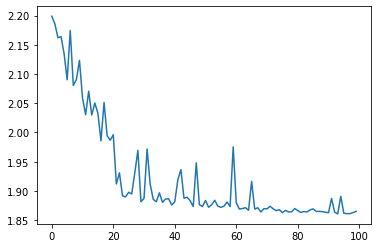

In [ ]:
sns.lineplot(x= range(len(batch_loss)), y= batch_loss);

# -------------------------------------------------

# Saving document embeddings

In [ ]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TRAIN_data, batch_size= 1)

In [ ]:
for idx in range(len(doc_idxs)):
    TRAIN_emb, TRAIN_labels = get_model_data_batched(doc_idxs[idx], batched_texts[idx], batched_labels[idx],label_encoder,max_lens_train)
    save_tensor(TRAIN_emb, '../train_document/doc_'+str(idx),"embedding")
    save_tensor(TRAIN_labels, '../train_document/doc_'+str(idx),"label")

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])
Tensor saved to '../train_document/doc_0/embedding'
Tensor saved to '../train_document/doc_0/label'
X_train size: torch.Size([72, 1, 768])	Y_train size: torch.Size([72])
Tensor saved to '../train_document/doc_1/embedding'
Tensor saved to '../train_document/doc_1/label'
X_train size: torch.Size([200, 1, 768])	Y_train size: torch.Size([200])
Tensor saved to '../train_document/doc_2/embedding'
Tensor saved to '../train_document/doc_2/label'
X_train size: torch.Size([119, 1, 768])	Y_train size: torch.Size([119])
Tensor saved to '../train_document/doc_3/embedding'
Tensor saved to '../train_document/doc_3/label'
X_train size: torch.Size([184, 1, 768])	Y_train size: torch.Size([184])
Tensor saved to '../train_document/doc_4/embedding'
Tensor saved to '../train_document/doc_4/label'
X_train size: torch.Size([211, 1, 768])	Y_train size: torch.Size([211])
Tensor saved to '../train_document/doc_5/embedding'
Tensor saved to '../

In [ ]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TEST_data, batch_size= 1)
max_lens_test = max_length(TEST_data)

In [ ]:
for idx in range(len(doc_idxs)):
    TEST_emb, TEST_labels = get_model_data_batched(doc_idxs[idx], batched_texts[idx], batched_labels[idx],label_encoder,max_lens_test)
    save_tensor(TEST_emb, '../test_document/doc_'+str(idx),"embedding")
    save_tensor(TEST_labels, '../test_document/doc_'+str(idx),"label")

X_train size: torch.Size([96, 1, 768])	Y_train size: torch.Size([96])
Tensor saved to '../test_document/doc_0/embedding'
Tensor saved to '../test_document/doc_0/label'
X_train size: torch.Size([139, 1, 768])	Y_train size: torch.Size([139])
Tensor saved to '../test_document/doc_1/embedding'
Tensor saved to '../test_document/doc_1/label'
X_train size: torch.Size([150, 1, 768])	Y_train size: torch.Size([150])
Tensor saved to '../test_document/doc_2/embedding'
Tensor saved to '../test_document/doc_2/label'
X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])
Tensor saved to '../test_document/doc_3/embedding'
Tensor saved to '../test_document/doc_3/label'
X_train size: torch.Size([97, 1, 768])	Y_train size: torch.Size([97])
Tensor saved to '../test_document/doc_4/embedding'
Tensor saved to '../test_document/doc_4/label'
X_train size: torch.Size([57, 1, 768])	Y_train size: torch.Size([57])
Tensor saved to '../test_document/doc_5/embedding'
Tensor saved to '../test_document/d

In [ ]:
load_tensor(f"../train_document/doc_{69}/embedding").size()

torch.Size([0, 1, 768])